In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from glob import glob
from keras.optimizers import SGD
from tqdm.notebook import tqdm

C:\Users\SamuelMcmurray\.conda\envs\tf\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Segmentation Models: using `keras` framework.


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
sm.set_framework('tf.keras')

In [4]:
dataDir='..'
dataType='train2017'
annFile='annotations_trainval2017/annotations/instances_{}.json'.format(dataType)
coco = COCO(annotation_file=annFile)

loading annotations into memory...
Done (t=13.94s)
creating index...
index created!


In [5]:
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

In [6]:
filter_classes = []
filter_classes_map = {}
for i in range(len(cats)):
    filter_classes.append(cats[i]['name'])
    filter_classes_map[cats[i]['name']] = cats[i]['id']

In [7]:
dataDir='stuff_trainval2017'
dataType='train2017'
annFile='{}/stuff_{}.json'.format(dataDir, dataType)

cocoGt = COCO(annFile)

loading annotations into memory...
Done (t=9.63s)
creating index...
index created!


In [8]:
cat_stuffIDs= cocoGt.getCatIds()
cats_stuff = cocoGt.loadCats(cat_stuffIDs)

In [9]:
for i in range(len(cats_stuff)):
    filter_classes.append(cats_stuff[i]['name'])
    filter_classes_map[cats_stuff[i]['name']] = cats_stuff[i]['id']

In [10]:
color_mapping = {0:(0,0,0)}
file = open(r'C:\Users\SamuelMcmurray\Documents\SchoolStuff\JU\DeepLearning\Project\deeplearning_project\coco\coco2017\color_map2.txt', 'r')
data = file.readlines()
for line in data:
    id_rgb = line.split(":")[1]
    digits = id_rgb.split(",")
    id = int(digits[0])
    r = int(digits[1])
    g = int(digits[2])
    b = int(digits[3])
    color_mapping[id] = (r, g, b)

In [11]:
filter_classes_map["unlabeled"] = 0
COLOR_MAP = [[131, 242, 30], [134, 241, 28], [137, 239, 26], [140, 238, 24], [143, 236, 23], [146, 235, 21], [149, 233, 19], [152, 231, 18], [155, 229, 16], [158, 228, 15], [161, 226, 14], [167, 222, 11], [170, 220, 10], [173, 217, 9], [176, 215, 8], [178, 213, 7], [181, 211, 6], [184, 208, 5], [187, 206, 4], [189, 204, 4], [192, 201, 3], [195, 199, 3], [197, 196, 2], [200, 193, 2], [205, 188, 1], [207, 185, 1], [214, 177, 1], [216, 174, 1], [218, 171, 1], [221, 169, 2], [223, 166, 2], [225, 163, 2], [227, 160, 3], [228, 157, 4], [230, 154, 4], [232, 151, 5], [234, 148, 6], [235, 145, 7], [237, 142, 7], [239, 139, 8], [241, 133, 11], [243, 130, 12], [244, 127, 13], [245, 124, 14], [246, 121, 16], [247, 118, 17], [248, 115, 19], [249, 111, 20], [250, 108, 22], [251, 105, 24], [252, 102, 26], [252, 99, 27], [253, 97, 29], [253, 94, 31], [254, 91, 33], [254, 88, 35], [255, 85, 37], [255, 82, 39], [255, 79, 42], [255, 76, 44], [255, 71, 49], [254, 63, 56], [253, 58, 61], [253, 55, 64], [252, 53, 66], [252, 50, 69], [251, 48, 72], [250, 46, 74], [249, 43, 77], [248, 41, 80], [247, 39, 83], [246, 37, 86], [245, 35, 89], [243, 31, 94], [241, 29, 97], [240, 27, 100], [238, 25, 103], [237, 23, 106], [235, 22, 109], [234, 20, 112], [230, 17, 118], [228, 15, 122], [226, 14, 125], [224, 13, 128], [222, 11, 131], [220, 10, 134], [218, 9, 137], [216, 8, 140], [214, 7, 143], [212, 6, 146], [209, 5, 149], [207, 5, 152], [204, 4, 155], [202, 3, 158], [199, 3, 161], [197, 2, 164], [194, 2, 167], [192, 2, 169], [189, 1, 172], [186, 1, 175], [184, 1, 178], [181, 1, 181], [178, 1, 184], [175, 1, 186], [172, 1, 189], [170, 2, 192], [167, 2, 194], [164, 2, 197], [161, 3, 199], [158, 3, 202], [155, 4, 204], [152, 5, 207], [149, 5, 209], [146, 6, 211], [143, 7, 214], [140, 8, 216], [137, 9, 218], [134, 10, 220], [131, 11, 222], [128, 13, 224], [125, 14, 226], [122, 15, 228], [119, 17, 230], [116, 18, 232], [112, 20, 234], [109, 21, 235], [106, 23, 237], [103, 25, 238], [100, 27, 240], [98, 29, 241], [95, 31, 243], [92, 32, 244], [89, 35, 245], [86, 37, 246], [83, 39, 247], [80, 41, 248], [77, 43, 249], [75, 45, 250], [72, 48, 251], [69, 50, 252], [66, 53, 252], [64, 55, 253], [61, 58, 253], [59, 60, 254], [56, 63, 254], [54, 65, 255], [51, 68, 255], [49, 71, 255], [46, 74, 255], [44, 76, 255], [42, 79, 255], [40, 82, 255], [37, 85, 255], [35, 88, 254], [33, 91, 254], [31, 93, 253], [29, 96, 253], [27, 99, 252], [26, 102, 252], [24, 105, 251], [22, 108, 250], [20, 111, 249], [19, 114, 248], [17, 117, 247], [16, 120, 246], [14, 124, 245], [13, 127, 244], [12, 130, 243], [11, 133, 241], [10, 136, 240], [8, 139, 239], [7, 142, 237], [0, 0, 0]]
CLASSES = []
for cl in filter_classes_map:
    CLASSES.append(cl)
    COLOR_MAP.append([color_mapping[filter_classes_map[cl]][0], color_mapping[filter_classes_map[cl]][1], color_mapping[filter_classes_map[cl]][2]])

In [12]:
globals()['IMAGE_SIZE'] = 128
globals()['BATCH_SIZE'] = 6
globals()['NUM_CLASSES'] = 173
globals()['IMAGE_DIR'] = r"C:\Users\SamuelMcmurray\Documents\SchoolStuff\JU\DeepLearning\Project\deeplearning_project\coco\coco2017"
globals()['MASK_DIR'] = r"C:\Users\SamuelMcmurray\Documents\SchoolStuff\JU\DeepLearning\Project\deeplearning_project\coco\coco2017\masks"
globals()['NUM_TRAIN_IMAGES'] = 10000
globals()['NUM_VAL_IMAGES'] = 1000

In [13]:
train_images = sorted(glob(os.path.join(IMAGE_DIR, "train2017/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(MASK_DIR, "train2017/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(IMAGE_DIR, "val2017/*")))[: NUM_VAL_IMAGES]
val_masks = sorted(glob(os.path.join(MASK_DIR, "val2017/*")))[:NUM_VAL_IMAGES]

In [14]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = x.astype(np.float32)

    return x

In [15]:
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))

    output = []
    for i, color in enumerate(COLOR_MAP):
        c_map = np.all(np.equal(x,color), axis=-1)
        output.append(c_map)
        save_image_path = os.path.join("result","resnet", ".png")
        cv2.imwrite(save_image_path, cat_images)

    output = np.stack(output, axis=-1)
    output = output.astype(np.uint8)

    return output

In [ ]:
x = read_image(train_masks[4])
def f(y):
    y = y.decode()
    y = read_mask(y)
mask = tf.numpy_function(f, [x], [tf.uint8])


In [16]:
def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.uint8])
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    mask.set_shape([IMAGE_SIZE, IMAGE_SIZE, NUM_CLASSES])
    return image, mask

In [17]:
def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(2)
    return dataset

In [18]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

In [19]:
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(6, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(6, 128, 128, 173), dtype=tf.uint8, name=None))>
Val Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(6, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(6, 128, 128, 173), dtype=tf.uint8, name=None))>


In [20]:
model = sm.Unet('resnet101', encoder_weights='imagenet', classes=NUM_CLASSES, activation='softmax', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [21]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy', keras.metrics.MeanIoU(num_classes=NUM_CLASSES, name="MeanIoU")]
model.compile(optimizer=SGD(learning_rate=2.5e-3), loss="categorical_crossentropy", metrics=metrics)

In [23]:
history = model.fit(train_dataset,batch_size=6, epochs=10, validation_data=val_dataset)

Epoch 1/10
1666/1666 [==============================] - 473s 283ms/step - loss: 0.5162 - accuracy: 0.0211 - MeanIoU: 0.4997 - val_loss: 0.5372 - val_accuracy: 0.0278 - val_MeanIoU: 0.4996
Epoch 2/10
1666/1666 [==============================] - 459s 275ms/step - loss: 0.4580 - accuracy: 0.0298 - MeanIoU: 0.4997 - val_loss: 0.5066 - val_accuracy: 0.0284 - val_MeanIoU: 0.4996
Epoch 3/10
1666/1666 [==============================] - 460s 276ms/step - loss: 0.4502 - accuracy: 0.0304 - MeanIoU: 0.4997 - val_loss: 0.5190 - val_accuracy: 0.0289 - val_MeanIoU: 0.4996
Epoch 4/10
1666/1666 [==============================] - 481s 288ms/step - loss: 0.4670 - accuracy: 0.0290 - MeanIoU: 0.4997 - val_loss: 0.5127 - val_accuracy: 0.0290 - val_MeanIoU: 0.4996
Epoch 5/10
1666/1666 [==============================] - 472s 283ms/step - loss: 0.5049 - accuracy: 0.0198 - MeanIoU: 0.4997 - val_loss: 0.6005 - val_accuracy: 0.0271 - val_MeanIoU: 0.4996
Epoch 6/10
1666/1666 [==============================] - 486s

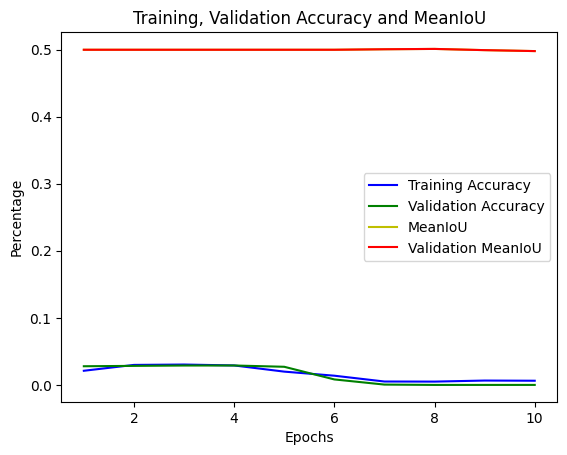

In [25]:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
mean_iou = history.history["MeanIoU"]
val_mean_iou = history.history["val_MeanIoU"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.plot(epochs, mean_iou, 'y', label='MeanIoU')
plt.plot(epochs, mean_iou, 'r', label='Validation MeanIoU')
plt.title('Training, Validation Accuracy and MeanIoU')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [26]:
model.save('../models/resnet_backbone.hdf5')

In [6]:
model = load_model('../models/resnet_backbone_shape.hdf5') # loading model...

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']   

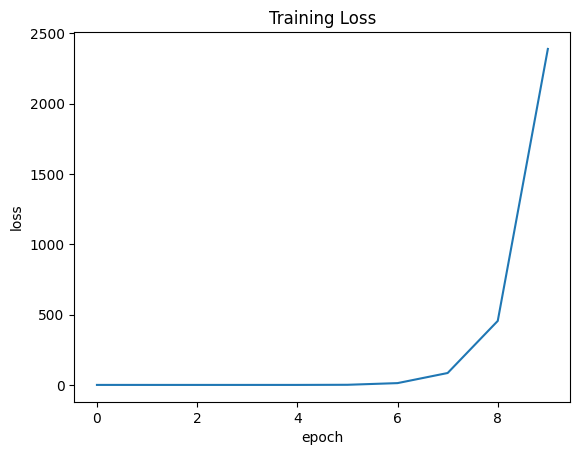

In [28]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

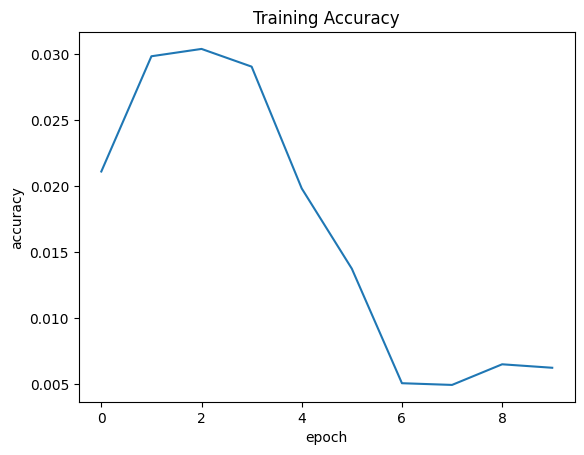

In [29]:
plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

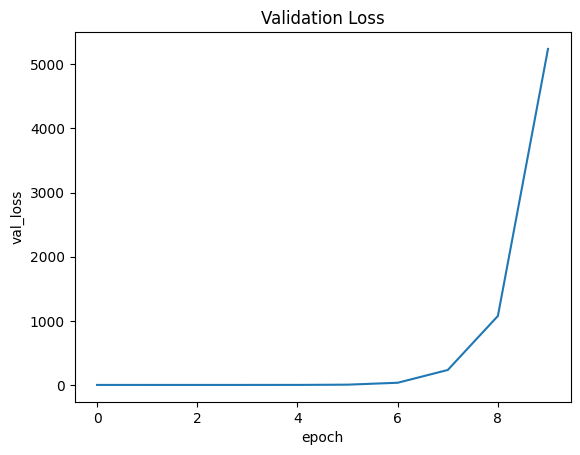

In [30]:
plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

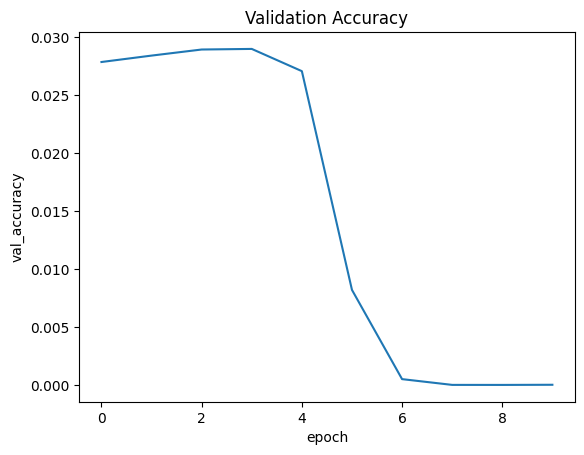

In [31]:
plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

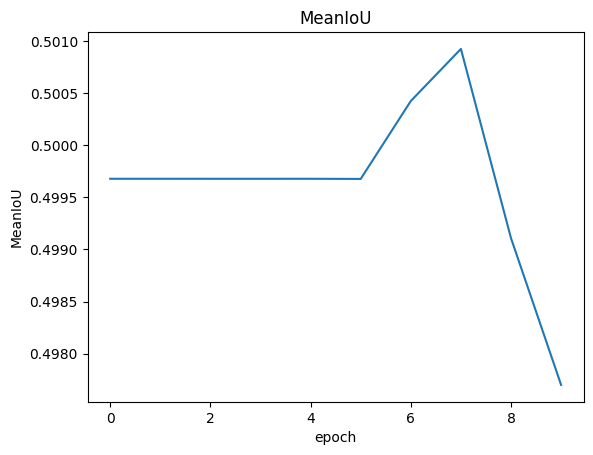

In [32]:
plt.plot(history.history["MeanIoU"])
plt.title("MeanIoU")
plt.ylabel("MeanIoU")
plt.xlabel("epoch")
plt.show()

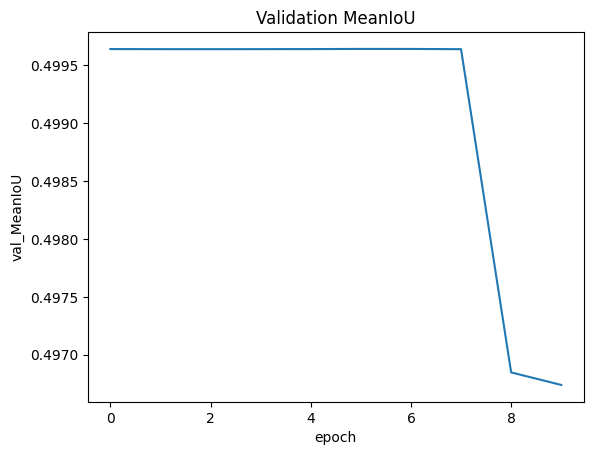

In [33]:
plt.plot(history.history["val_MeanIoU"])
plt.title("Validation MeanIoU")
plt.ylabel("val_MeanIoU")
plt.xlabel("epoch")
plt.show()

1/1 [==============================] - 1s 1s/step


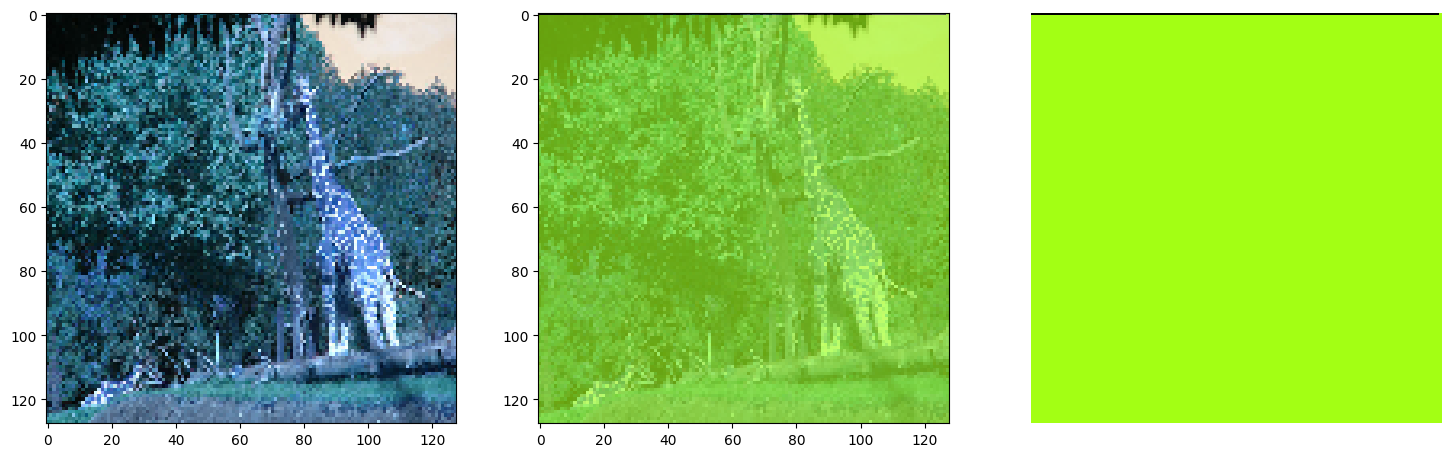

1/1 [==============================] - 0s 35ms/step


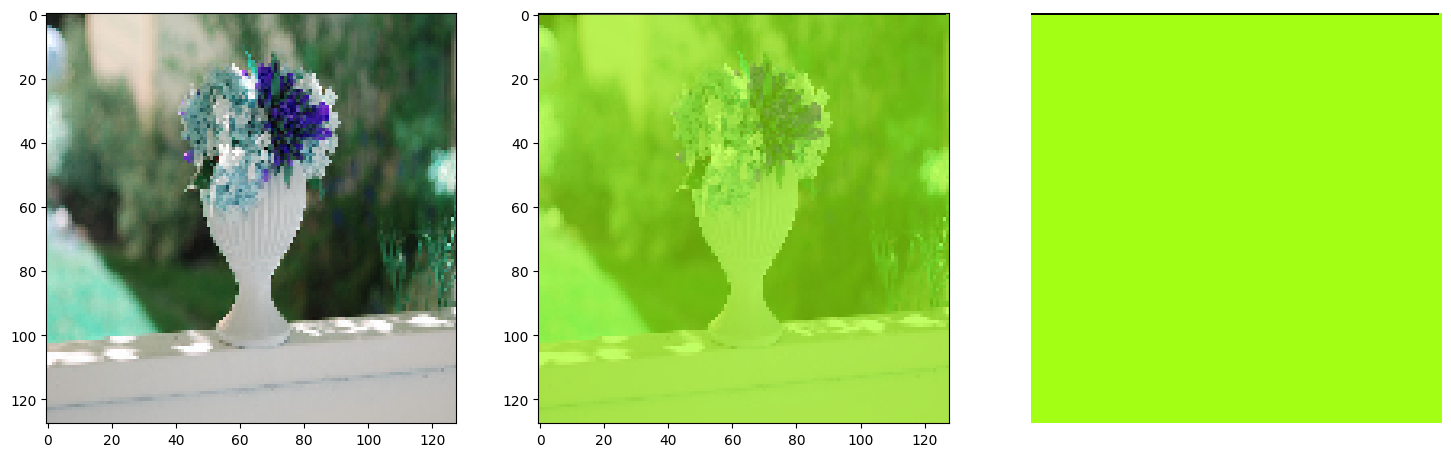

1/1 [==============================] - 0s 31ms/step


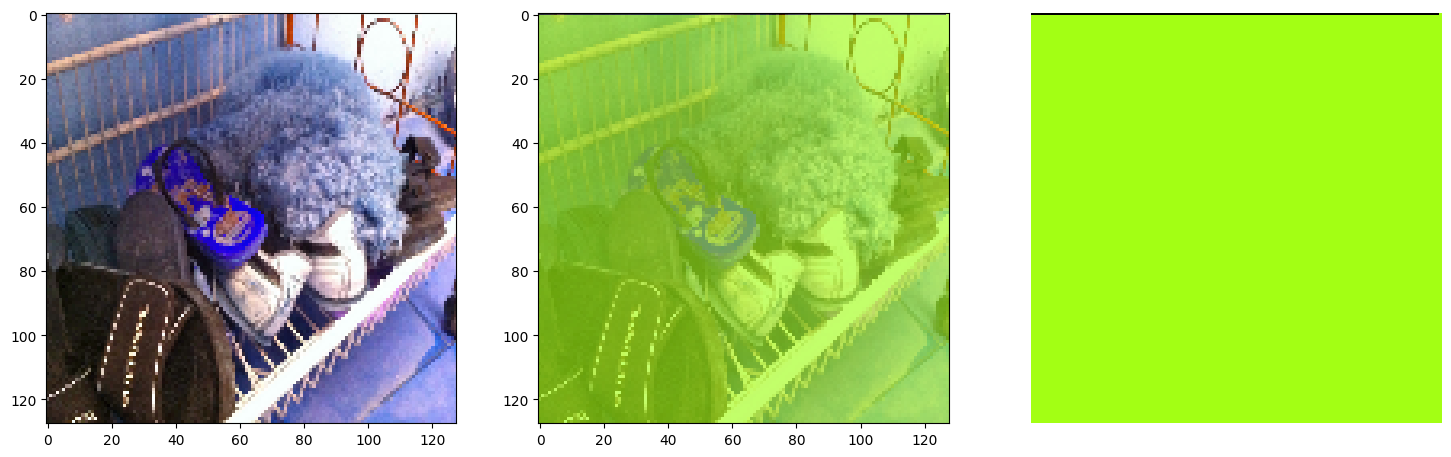

1/1 [==============================] - 0s 29ms/step


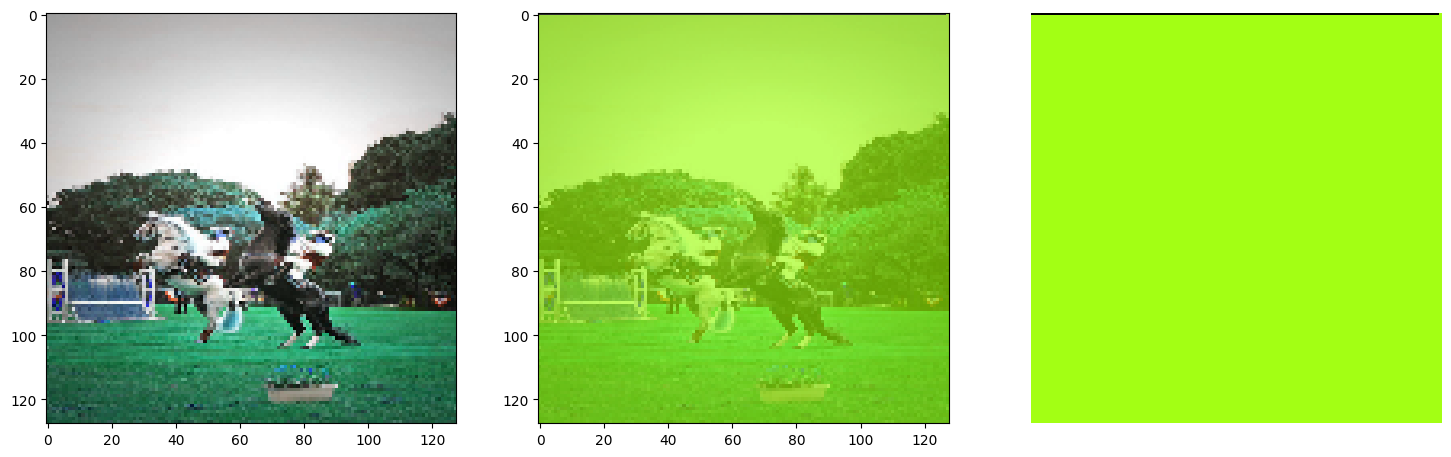

In [39]:
def grayscale_to_rgb(pred,classes, colormap):
    h,w, _ = pred.shape
    pred = pred.astype(np.int32)

    output=[]
    for i, pixel in enumerate(pred.flatten()):
        output.append(colormap[pixel])

    output = np.reshape(output, (h,w,3))
    return output

In [ ]:
def save_image_pred(image_x, mask_x, pred, save_image_path):
    # print(image_x.shape, mask_x.shape, pred.shape)
    h,w,_ = image_x.shape
    line = np.ones((h,30,3)) * 255
    pred = np.expand_dims(pred, axis=-1)
    pred = grayscale_to_rgb(pred,CLASSES, COLOR_MAP)

    cat_images = np.concatenate([image_x, line, mask_x, line, pred])
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
SCORE = []
for x, y in tqdm(zip(val_images, val_masks), total=len(1000)):
    name = x.split("/")[-1].split(".")[0]
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image_x = image
    image = image/255.0
    image = np.expand_dims(image, axis=0)

    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
    mask_x = mask
    onehot_mask = []
    for color in COLOR_MAP:
        cmap = np.all(np.equal(mask, color), axis=-1)
        onehot_mask.append(cmap)
    onehot_mask = np.stack(onehot_mask, axis=-1)
    onehot_mask = np.argmax(onehot_mask, axis=-1)
    onehot_mask = onehot_mask.astype(np.int32)

    pred = model.predict(image, verbose=0)[0]
    print(pred.shape)
    pred = np.argmax(pred, axis=-1)
    pred = pred.astype(np.float32)

    save_image_path = os.path.join("result","resnet", "{}.png".format(name))